# Assignment: Climate change in the CESM simulations

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

## Part 1

Following the examples in the [lecture notes](https://brian-rose.github.io/ClimateLaboratoryBook/courseware/transient-cesm.html), open the four CESM simulations (fully coupled and slab ocean versions). 

Calculate timeseries of **global mean ASR and OLR** and store each of these as a new variable. *Recall that ASR is called `FSNT` in the CESM output, and OLR is called `FLNT`.*

Plot a timeseries of **(ASR - OLR), the net downward energy flux at the top of the model**, along with a **12 month rolling mean**, analogous to the plot of global mean surface air temperature in the lecture notes.  

*Note that the rolling mean is important here because, just like with surface air temperature, there is a large seasonal cycle which makes it harder to see evidence of the climate change signal we wish to focus on.*

*Copy Brian's code*

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
casenames = {'cpl_control': 'cpl_1850_f19',
             'cpl_CO2ramp': 'cpl_CO2ramp_f19',
             'som_control': 'som_1850_f19',
             'som_2xCO2':   'som_1850_2xCO2',
            }
# The path to the THREDDS server, should work from anywhere
basepath = 'http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/'
# For better performance if you can access the roselab_rit filesystem (e.g. from JupyterHub)
#basepath = '/roselab_rit/cesm_archive/'
casepaths = {}
for name in casenames:
    casepaths[name] = basepath + casenames[name] + '/concatenated/'

In [8]:
# make a dictionary of all the CAM atmosphere output
atm = {}
for name in casenames:
    path = casepaths[name] + casenames[name] + '.cam.h0.nc'
    print('Attempting to open the dataset ', path)
    atm[name] = xr.open_dataset(path, decode_times=False)

Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_1850_f19/concatenated/cpl_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/cpl_CO2ramp_f19/concatenated/cpl_CO2ramp_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_f19/concatenated/som_1850_f19.cam.h0.nc
Attempting to open the dataset  http://thredds.atmos.albany.edu:8080/thredds/dodsC/CESMA/som_1850_2xCO2/concatenated/som_1850_2xCO2.cam.h0.nc


*Calculate timeseries of global mean ASR and OLR and store each of these as a new variable*

In [4]:
atm.keys()

dict_keys(['cpl_control', 'cpl_CO2ramp', 'som_control', 'som_2xCO2'])

In [21]:
globmean_ASR = {}
globmean_OLR = {}
net_flux = {}

# dont forget about this part
weight_factor = atm["cpl_control"].gw / atm["cpl_control"].gw.mean(dim="lat")

# this takes a while to run
for key in atm.keys():
    globmean_ASR[key] = (atm[key].FSNT * weight_factor).mean(dim=("lon", "lat"))
    globmean_OLR[key] = (atm[key].FLNT * weight_factor).mean(dim=("lon", "lat"))
    net_flux[key] = globmean_ASR[key] - globmean_OLR[key]


In [26]:
days_per_year = 365

*Plot a timeseries of (ASR - OLR), the net downward energy flux at the top of the model, along with a 12 month rolling mean, analogous to the plot of global mean surface air temperature in the lecture notes.*

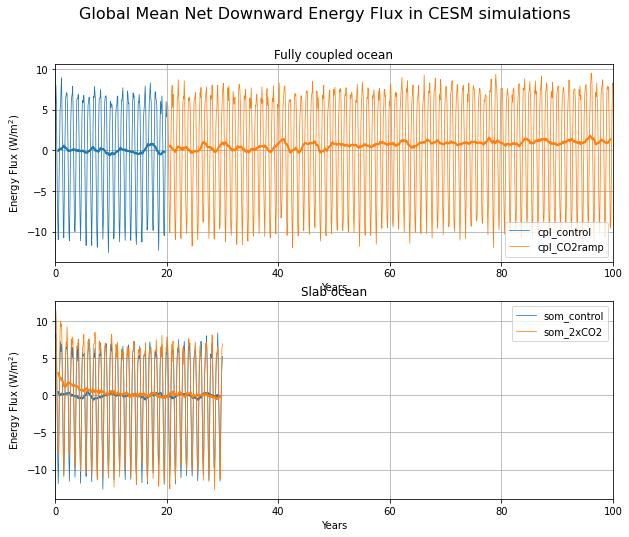

In [28]:
fig, axes = plt.subplots(2,1,figsize=(10,8))
for name in casenames:
    if 'cpl' in name:
        ax = axes[0]
        ax.set_title('Fully coupled ocean')
    else:
        ax = axes[1]
        ax.set_title('Slab ocean')
    field = net_flux[name]
    field_running = field.rolling(time=12, center=True).mean()
    line = ax.plot(field.time / days_per_year, 
                   field, 
                   label=name,
                   linewidth=0.75,
                   )
    ax.plot(field_running.time / days_per_year, 
            field_running, 
            color=line[0].get_color(),
            linewidth=2,
           )
for ax in axes:
    ax.legend();
    ax.set_xlabel('Years')
    ax.set_ylabel('Energy Flux (W/m$^2$)')
    ax.grid();
    ax.set_xlim(0,100)
fig.suptitle('Global Mean Net Downward Energy Flux in CESM simulations', fontsize=16);

## Part 2

Calculate and show the **time-average ASR** and **time-average OLR** over the final 10 or 20 years of each simulation. Following the lecture notes, use the 20-year slice for the fully coupled simulations, and the 10-year slice for the slab ocean simulations.

In [29]:
nyears_slab = 10
nyears_cpl = 20
clim_slice_slab = slice(-(nyears_slab*12),None)
clim_slice_cpl = slice(-(nyears_cpl*12),None)

In [50]:
# extract the last 10 years from the slab ocean control simulation
flux0_slab = net_flux['som_control'].isel(time=clim_slice_slab).mean(dim='time')
# extract the last 10 years from the slab 2xCO2 simulation
flux2x_slab = net_flux['som_2xCO2'].isel(time=clim_slice_slab).mean(dim='time')
# and the last 20 years from the coupled control
flux0_cpl = net_flux['cpl_control'].isel(time=clim_slice_cpl).mean(dim='time')
# extract the last 20 years from the coupled CO2 ramp simulation
flux2x_cpl = net_flux['cpl_CO2ramp'].isel(time=clim_slice_cpl).mean(dim='time')

## Part 3

Based on your plots and numerical results from Parts 1 and 2, answer these questions:

1. Are the two control simulations (fully coupled and slab ocean) near energy balance?
2. In the fully coupled CO2 ramp simulation, does the energy imbalance (ASR-OLR) increase or decrease with time? What is the imbalance at the end of the 80 year simulation?
3. Answer the same questions for the slab ocean abrupt 2xCO2 simulation.
4. Explain in words why the timeseries of ASR-OLR look very different in the fully coupled simulation (1%/year CO2 ramp) versus the slab ocean simulation (abrupt 2xCO2). *Think about both the different radiative forcings and the different ocean heat capacities.*

In [44]:
# 1.
print(f'slab control energy flux: {flux0_slab.values} W/m2')
print(f'coupled control energy flux: {flux0_cpl.values} W/m2')

slab control energy flux: -0.07825682684431333 W/m2
coupled control energy flux: -0.024331278396431937 W/m2


*1. Both control runs are near energy balance.* 

*2. In the fully coupled ramp simulation, we can see from the figure that the imbalance slowly increases from 0 to a final value near 1. We could eliminate some of the noise using a longer time average*

In [49]:
# 2.
print(f'coupled ramp energy flux at simulation end: {flux2x_cpl.values} W/m2')

coupled ramp energy flux at simulation end: 1.0295490474654279 W/m2


*3. From the plot, we see the slab ocean CO$_2$ step starts far from equilibrium (instant forcing caused by the CO$_2$ doubling), then returns to energy balance as the temperature rises (Planck feedback)*

In [52]:
# 3.
print(f'slab step energy flux at simulation end: {flux2x_slab.values} W/m2')

slab step energy flux at simulation end: 0.0024441657542406386 W/m2


*4. The slab ocean simulation is a simple demonstration of Planck feedback. CO$_2$ forces an imbalance (ASR > OLR) and the planet adjusts by warming (increasing OLR) until equilibrium is restored.*

*In the fully coupled ocean model, CO$_2$ forcing isnt nearly as large at any point in time as with the step, so the planet warms more slowly to adjust to the increased CO$_2$. The response is slowed further by the fact that the fully coupled ocean is a much larger energy sink compared with the slab, and so ASR "accumulates" over time since the planet cannot increase OLR fast enough to equilibriate.*

## Part 4

Does the global average ASR **increase** or **decrease** because of CO2-driven warming in the CESM? 

Would you describe this as a **positive** or **negative** feedback?

## Part 5

In the previous question you looked at the global average change in ASR. Now I want you to look at how different parts of the world contribute to this change.

**Make a map** of the **change in ASR** due to the CO2 forcing. Use the average over the last 20 years of the coupled CO2 ramp simulation, comparing against the average over the last 20 years of the control simulation.

## Part 6

Repeat part 5, but this time instead of the change in ASR, look at the just change in the **clear-sky** component of ASR. You can find this in the output field called `FSNTC`.

*The `FSNTC` field shows shortwave absorption in the absence of clouds, so the **change** in `FSNTC` shows how absorption and reflection of shortwave are affected by processes other than clouds.*

## Part 7

Discussion:

- Do your two maps (change in ASR, change in clear-sky ASR) look the same? 
- Offer some ideas about why the clear-sky map looks the way it does.
- Comment on anything interesting, unusual or surprising you found in the maps.

____________

## Credits

This notebook is part of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook), an open-source textbook developed and maintained by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It is licensed for free and open consumption under the
[Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/) license.

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________